## Dependecies:
- numpy, pandas, matplotlib, seaborn, sklearn, keras, pydot
# Read in training and testing data and do some housekeeping:
1. Remove duplicate rows
2. Split both datasets into an n-dim feature/design matrix and 1-dim target/predictor vector
3. Manually encode a value to the binary categorical labels of the target/predictor vector

In [1]:
import numpy as np
import pandas as pd


# Read in the data, note: 'education-num' is a proxy for level education
dataTypes = {'age':np.uint8,'workclass':'category', 'fnlwgt':np.uint32, 'education':'category', 'education-num':np.uint8,
             'marital-status':'category', 'occupation':'category', 'relationship':'category', 'race':'category', 'sex':'category', 
             'capital-gain':np.uint32, 'capital-loss':np.uint32, 'hours-per-week':np.uint8, 'native-country':'category',
             'class':'category'}


# Note, we have a mixture of categorical and numerical data,
df_train = pd.read_csv('trainingData/au_train.csv', dtype=dataTypes, skipinitialspace=True, engine='c')
df_test = pd.read_csv('testingData/au_test.csv', dtype=dataTypes, skipinitialspace=True ,engine='c')


# Shuffle training set
df_train = df_train.sample(frac=1)#random_state,weights


# Check for duplicate rows
# print(df_train.drop(columns=['class']).drop_duplicates(inplace=True))
# print(df_test.drop(columns=['class']).drop_duplicates(inplace=True))


# Check to see that samples do not have both a non-zero 'capital-gain' and 'capital-loss'
# checkGain = np.where(df_train['capital-gain'].to_numpy()>0,1,0)
# checkLoss = np.where(df_train['capital-loss'].to_numpy()>0,1,0)
# maxOfSumGainLoss = max(checkGain+checkLoss)
# print(maxOfSumGainLoss)


# Check some information and for bad values
# print('\nCheck some prelimiary info and for missing values/NaN:')
# print(df_train.info(),df_test.info())
# print(df_train.describe(),df_test.describe())


# Check for unlabeled categorical features in our DataFrames / misspellings
# print(sorted(list(df_train['workclass'].unique())))
# print(sorted(list(df_train['occupation'].unique())))
# print(sorted(list(df_train['native-country'].unique())))
# print(sorted(list(df_test['workclass'].unique())))
# print(sorted(list(df_test['occupation'].unique())))
# print(sorted(list(df_test['native-country'].unique())))


# I feel `education` and `education-num` is redundant since `education-num` is an ordinally encoded
# version of `education` category that is order by level of education (good), I'll drop the category
# df_train = df_train.drop(columns=['education'])
# df_test = df_test.drop(columns=['education'])
# df_train = df_train.drop(columns=['fnlwgt'])
# df_test = df_test.drop(columns=['fnlwgt'])
# df_train = df_train.drop(columns=['capital-gain'])
# df_test = df_test.drop(columns=['capital-gain'])
# df_train = df_train.drop(columns=['capital-loss'])
# df_test = df_test.drop(columns=['capital-loss'])
df_train = df_train.drop(columns=['education-num'])
df_test = df_test.drop(columns=['education-num'])
df_train = df_train.drop(columns=['relationship'])
df_test = df_test.drop(columns=['relationship'])

# Check for misspelled labels
# categories = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','class']
categories = [catFeat for catFeat in df_train.select_dtypes(include="category")]
for cat in categories:
    a = set(df_train[cat].unique())
    b = set(df_test[cat].unique())
    if len(a.difference(b)):
        print('\nProblem while checking for missing/bad labels:')
        print('Categories in `%s` column of df_train not in df_test:'%cat,a.difference(b))
        print('Categories in `%s` column of df_test not in df_train:'%cat,b.difference(a))

# Note: The test sets target has an extraneous '.' at the end. Handle this manually later
# In addition there is no entry for 'Holand-Netherlands' in the test set so you could argue that data 
# to train on may not be needed
print('\n\n# of entries before dropping Holand-Netherlands:',len(df_train))
# df_train = df_train.replace('Holand-Netherlands',-1)
# print(df_train.query('`native-country`==-1',engine='python'))
df_train = df_train.replace('Holand-Netherlands',np.nan).dropna()
print('# of entries after dropping Holand-Netherlands:',len(df_train))



# Have some unlabeled/missing values (i.e '?') of categorical features in: 
#                'workclass','occupation','native-country'
# in both our training and testing DataFrame (categorical), need to drop those
print('\n\n# of rows in df_train before dropping unlabeled/missing values:',len(df_train))
df_train = df_train.replace('?',np.nan).dropna()
print('# of rows in df_train after dropping unlabeled/missing values:',len(df_train))
print('\n\n# of rows in df_test before dropping unlabeled/missing values:',len(df_test))
df_test = df_test.replace('?',np.nan).dropna()
print('# of rows in df_test after dropping unlabeled/missing values:',len(df_test))


# Split our data into 'X' commonly referred to as the 'Design Matrix' which contains our 
# 'predictors/features' and 'y' containing our prediction labels
y_train = df_train['class'].to_numpy()
X_train = df_train.drop(columns=['class'])

y_test = df_test['class'].to_numpy()
X_test = df_test.drop(columns=['class'])


# Manually encode (easy to do for a 1d array) a numerical value for our predictor which had
# a binary value
#            <=50K  --->    0
#             >50K  --->    1
y_train = np.where(y_train=='>50K',1,0)
y_test = np.where(y_test=='>50K.',1,0) # Handling that extra period '.'


# Check to see the distribution of the predictors in both sets
print('\n\nTraining predictor has',len(y_train),'samples and',np.sum(y_train),'of those samples \
are classified as >50K')
print('% of training sample >50K:',np.sum(y_train)/len(y_train))
print('% of training sample <=50K:',1-np.sum(y_train)/len(y_train))
print('\n\nTesting predictor has',len(y_test),'samples and',np.sum(y_test),'of those samples \
are classified as `>50K`')
print('% of testing sample >50K:',np.sum(y_test)/len(y_test))
print('% of testing sample <=50K:',1-np.sum(y_test)/len(y_test))


Problem while checking for missing/bad labels:
Categories in `native-country` column of df_train not in df_test: {'Holand-Netherlands'}
Categories in `native-country` column of df_test not in df_train: set()

Problem while checking for missing/bad labels:
Categories in `class` column of df_train not in df_test: {'<=50K', '>50K'}
Categories in `class` column of df_test not in df_train: {'>50K.', '<=50K.'}


# of entries before dropping Holand-Netherlands: 32561
# of entries after dropping Holand-Netherlands: 32560


# of rows in df_train before dropping unlabeled/missing values: 32560
# of rows in df_train after dropping unlabeled/missing values: 30161


# of rows in df_test before dropping unlabeled/missing values: 16281
# of rows in df_test after dropping unlabeled/missing values: 15060


Training predictor has 30161 samples and 7508 of those samples are classified as >50K
% of training sample >50K: 0.24893073837074367
% of training sample <=50K: 0.7510692616292564


Testing predicto

# Note: There is more data for people making  <=50K, The target distribution in both training and testing data is the same but imbalanced

## Poke around the data to see if any of the features are skewed or may need scaling
## Visualization

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.colors import LogNorm

groupbySex = X_test.groupby('sex')
colorDict = {'Male':'b','Female':'r'}
for sex,group in groupbySex:
#     print(sex)
#     print(group.describe(),'\n\n')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.patch.set_facecolor('xkcd:gray')
    fig.suptitle(sex)
    group.plot(x='capital-gain',y='age',kind='scatter',ax=axes[0,0], c=colorDict[str(sex)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-gain',y='education-num',kind='hexbin',ax=axes[0,1],gridsize=15,cmap='viridis',norm=LogNorm())
    group.plot(x='capital-loss',y='age',kind='scatter',ax=axes[1,0],c=colorDict[str(sex)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-loss',y='education-num',kind='hexbin',ax=axes[1,1],gridsize=15,cmap='viridis',norm=LogNorm())

groupbyRace = X_test.groupby('race')
colorDict = {'White':'r','Asian-Pac-Islander':'g','Amer-Indian-Eskimo':'b','Other':'c','Black':'m'}
for race,group in groupbyRace:
#     print(sex)
#     print(group.describe(),'\n\n')
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.patch.set_facecolor('xkcd:gray')
    fig.suptitle(race)
    group.plot(x='capital-gain',y='age',kind='scatter',ax=axes[0,0], c=colorDict[str(race)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-gain',y='education-num',kind='hexbin',ax=axes[0,1],gridsize=15,cmap='viridis',norm=LogNorm())
    group.plot(x='capital-loss',y='age',kind='scatter',ax=axes[1,0],c=colorDict[str(race)],label=sex,legend=True,alpha=.4)
    group.plot(x='capital-loss',y='education-num',kind='hexbin',ax=axes[1,1],gridsize=15,cmap='viridis',norm=LogNorm())
    
    
# Plot correlation matrix
labelNames = [numFeat for numFeat in X_train.select_dtypes(include=np.number)]
corr = X_train[labelNames[:]].corr()


im = plt.matshow(corr,cmap='viridis',interpolation='bilinear',norm=LogNorm())
plt.xticks(np.arange(corr.shape[1]),labels=labelNames,rotation=45,va='bottom',ha='left')
plt.yticks(np.arange(corr.shape[0]),labels=labelNames)
plt.colorbar(im)

## Visualization of categorical data

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Left plots belong to train and Right plots belong to test
# PLot sample distribution of race for training and test set
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.countplot(x='race', hue='sex',ax=axes[0],data=df_train)
sns.countplot(x='race', hue='sex',ax=axes[1],data=df_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.countplot(x='education-num', hue='race',ax=axes[0],data=df_train)
sns.countplot(x='education-num', hue='race',ax=axes[1],data=df_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.countplot(y='age',ax=axes[0],data=df_train)
sns.countplot(y='age',ax=axes[1],data=df_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.countplot(x='education-num',ax=axes[0],data=df_train)
sns.countplot(x='education-num',ax=axes[1],data=df_test)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
sns.countplot(y='occupation', hue='sex',ax=axes[0],data=df_train)
sns.countplot(y='occupation', hue='sex',ax=axes[1],data=df_test)

# The data is still heterogeneous(mixed numerical and categorical data), *scikit-learn* requires explicit conversion of categorical features to numeric values (**preprocessing**).
1. Possibility to scale the numeric features (helpful sometimes i.e convergence)
2. Categorical data will be *OneHotEncoded* to guarantee model sensitivity only to the original category labels

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

# Create the preprocessing pipelines for categorical data of training set.
train_numeric_features = [numFeat for numFeat in X_train.select_dtypes(include=np.number)]
train_numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])

train_categorical_features = [catFeat for catFeat in X_train.select_dtypes(include="category")]
train_categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', train_numeric_transformer, train_numeric_features),
        ('cat', train_categorical_transformer, train_categorical_features)],
        remainder='passthrough') # Don't drop untransformed columns

preprocessorNoScale = ColumnTransformer(
    transformers=[
        ('cat', train_categorical_transformer, train_categorical_features)],
        remainder='passthrough') # Don't drop untransformed columns

# Create pipelines with different scales
pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # RobustScale
pipeNoScale = Pipeline(steps=[('preprocessor', preprocessorNoScale)])

X_trainTrans = X_train.copy()
X_testTrans = X_test.copy()
X_trainTransNoScale = X_train.copy()
X_testTransNoScale = X_test.copy()

# Transform the sets
X_trainTrans = pipe.fit_transform(X=X_trainTrans,y=y_train)
X_testTrans = pipe.transform(X=X_testTrans)
X_trainTransNoScale = pipeNoScale.fit_transform(X=X_trainTransNoScale,y=y_train)
X_testTransNoScale = pipeNoScale.transform(X=X_testTransNoScale)

# print(X_trainTrans.shape)
# print(y_train.shape)
# print(X_testTrans.shape)
# print(y_test.shape)

# The data has been preprocessed and transformed, lets play with some models (classification algorithms)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# RobustScaled features
logr_clf = LogisticRegressionCV(cv=3,random_state=42,solver='lbfgs',max_iter=1000)
logr_clf.fit(X=X_trainTrans,y=y_train,sample_weight=None)
logr_pred = logr_clf.predict(X_testTrans)
print('logr score:',logr_clf.score(X=X_trainTrans,y=y_train,sample_weight=None)) # This is accuracy in getting the label correct


# No scale features
logrNoScale_clf = LogisticRegressionCV(cv=3,random_state=42,solver='lbfgs',max_iter=1000)
logrNoScale_clf.fit(X=X_trainTransNoScale,y=y_train,sample_weight=None)
# logrNoScale_pred = logrNoScale_clf.predict(X_testTransNoScale)
print('logrNoScale score:',logrNoScale_clf.score(X=X_trainTransNoScale,y=y_train,sample_weight=None))
# lr score is mean accuracy value -> Seems decent but remember the classes are imbalanced
# 75% of data is >50K and 25% is <=50K. ACCURACY IS NOT A GOOD METRIC

# Try F1 score metric
# Using our model create array holding its predicitions
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
y_test_pred = cross_val_predict(logr_clf, X_testTrans, y_test, cv=3)
f1Score = f1_score(y_true=y_test,y_pred=y_test_pred)
print('logr f1:',f1Score)


# Makes some plots
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,plot_precision_recall_curve
plot_roc_curve(logr_clf,X_testTrans,y_test,name='LogR w/ scaled features')
plot_precision_recall_curve(logr_clf,X_testTrans,y_test,name='LogR w/ scaled features')
plot_confusion_matrix(logr_clf,X_testTrans,y_test,display_labels=['<=50K','>50K'])



# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import make_scorer

# scoring = {'AUC': 'roc_auc', 'F1': make_scorer(f1_score), 'precision': 'precision', 'recall': 'recall'}
# grid = GridSearchCV(estimator=LogisticRegressionCV(solver='lbfgs',random_state=42,max_iter=1000),
#                     param_grid={'Cs':[10],'cv': [3, 4, 5]},
#                     scoring=scoring, refit='AUC', return_train_score=True)

# grid.fit(X_trainTrans, y_train)
# y_test_pred = grid.predict(X_testTrans)
# results = grid.cv_results_
# # print(results)

# f1Score = f1_score(y_true=y_test,y_pred=y_test_pred)
# print('logr f1 score GridSearchCV:',f1Score)

# Random Forest

rf_clf f1 test score: 0.6606668633815285
Random Forest classifier metrics (5-fold cross validation):
AUC:  [0.90047082 0.89999443 0.90197383 0.90607916 0.90434946]
f1:  [0.67216643 0.67293777 0.66691149 0.67888563 0.67673049]
precision:  [0.72861586 0.73634204 0.74304419 0.75530179 0.75700165]
recall:  [0.62383489 0.61958694 0.60493005 0.61651132 0.61185087]
accuracy:  [0.84849992 0.85013263 0.84963528 0.85477454 0.85444297]


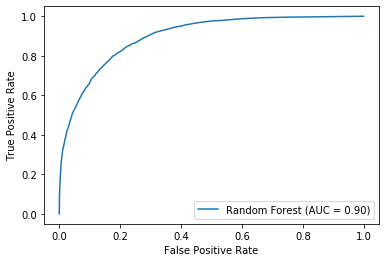

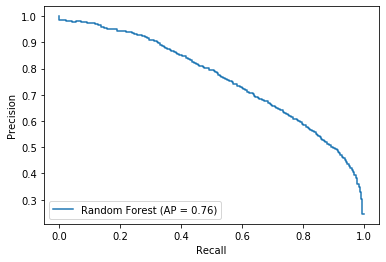

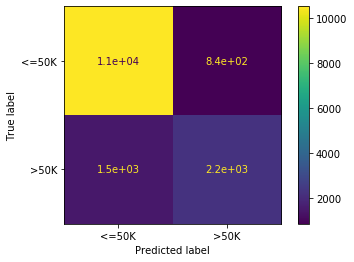

In [3]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=150,n_jobs=-1,class_weight='balanced')
rf_clf = rf_clf.fit(X_trainTrans, y_train)
y_test_pred = rf_clf.predict(X=X_testTrans)

from sklearn.metrics import f1_score
f1Score = f1_score(y_true=y_test,y_pred=y_test_pred)
print('rf_clf f1 test score:',f1Score)


# Makes some plots
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,plot_precision_recall_curve
plot_roc_curve(rf_clf,X_testTrans,y_test,name='Random Forest')
plot_precision_recall_curve(rf_clf,X_testTrans,y_test,name='Random Forest')
plot_confusion_matrix(rf_clf,X_testTrans,y_test,display_labels=['<=50K','>50K'])


from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
scoring = {'AUC': 'roc_auc', 'F1': make_scorer(f1_score), 'precision': 'precision', 'recall': 'recall', 'accuracy':'accuracy'}
results = cross_validate(estimator=rf_clf, X=X_trainTrans, y=y_train,scoring=scoring,cv=5,n_jobs=-1)
sorted(results.keys())

print('Random Forest classifier metrics (5-fold cross validation):')
print('AUC: ',results['test_AUC'])
print('f1: ',results['test_F1'])
print('precision: ',results['test_precision'])
print('recall: ',results['test_recall'])
print('accuracy: ',results['test_accuracy'])

# Keras (Deep Learning)

## Multilayer Perceptron (for binary classification)

Using TensorFlow backend.


Train on 21112 samples, validate on 9049 samples
Epoch 1/100
21112/21112 [==============================] - 1s 46us/step - loss: 19.3388 - tp: 1450.0000 - fp: 1098.0000 - tn: 14795.0000 - fn: 3769.0000 - accuracy: 0.7695 - precision: 0.5691 - recall: 0.2778 - auc: 0.7345 - val_loss: 2.2114 - val_tp: 854.0000 - val_fp: 391.0000 - val_tn: 6369.0000 - val_fn: 1435.0000 - val_accuracy: 0.7982 - val_precision: 0.6859 - val_recall: 0.3731 - val_auc: 0.8076
Epoch 2/100
21112/21112 [==============================] - 1s 33us/step - loss: 4.9318 - tp: 2066.0000 - fp: 1310.0000 - tn: 14583.0000 - fn: 3153.0000 - accuracy: 0.7886 - precision: 0.6120 - recall: 0.3959 - auc: 0.7903 - val_loss: 0.4583 - val_tp: 1320.0000 - val_fp: 710.0000 - val_tn: 6050.0000 - val_fn: 969.0000 - val_accuracy: 0.8145 - val_precision: 0.6502 - val_recall: 0.5767 - val_auc: 0.8715
Epoch 3/100
21112/21112 [==============================] - 1s 33us/step - loss: 1.5206 - tp: 2404.0000 - fp: 1438.0000 - tn: 14455.0000 - fn

21112/21112 [==============================] - 1s 37us/step - loss: 0.3425 - tp: 3036.0000 - fp: 1144.0000 - tn: 14749.0000 - fn: 2183.0000 - accuracy: 0.8424 - precision: 0.7263 - recall: 0.5817 - auc: 0.8954 - val_loss: 0.3506 - val_tp: 1196.0000 - val_fp: 336.0000 - val_tn: 6424.0000 - val_fn: 1093.0000 - val_accuracy: 0.8421 - val_precision: 0.7807 - val_recall: 0.5225 - val_auc: 0.8961
Epoch 22/100
21112/21112 [==============================] - 1s 40us/step - loss: 0.3428 - tp: 3068.0000 - fp: 1117.0000 - tn: 14776.0000 - fn: 2151.0000 - accuracy: 0.8452 - precision: 0.7331 - recall: 0.5879 - auc: 0.8953 - val_loss: 0.3439 - val_tp: 1300.0000 - val_fp: 349.0000 - val_tn: 6411.0000 - val_fn: 989.0000 - val_accuracy: 0.8521 - val_precision: 0.7884 - val_recall: 0.5679 - val_auc: 0.9000
Epoch 23/100
21112/21112 [==============================] - 1s 36us/step - loss: 0.3423 - tp: 3066.0000 - fp: 1146.0000 - tn: 14747.0000 - fn: 2153.0000 - accuracy: 0.8437 - precision: 0.7279 - recall

21112/21112 [==============================] - 1s 34us/step - loss: 0.3303 - tp: 3197.0000 - fp: 1068.0000 - tn: 14825.0000 - fn: 2022.0000 - accuracy: 0.8536 - precision: 0.7496 - recall: 0.6126 - auc: 0.9034 - val_loss: 0.3355 - val_tp: 1351.0000 - val_fp: 377.0000 - val_tn: 6383.0000 - val_fn: 938.0000 - val_accuracy: 0.8547 - val_precision: 0.7818 - val_recall: 0.5902 - val_auc: 0.9036
Epoch 42/100
21112/21112 [==============================] - 1s 34us/step - loss: 0.3318 - tp: 3197.0000 - fp: 1078.0000 - tn: 14815.0000 - fn: 2022.0000 - accuracy: 0.8532 - precision: 0.7478 - recall: 0.6126 - auc: 0.9028 - val_loss: 0.3358 - val_tp: 1348.0000 - val_fp: 375.0000 - val_tn: 6385.0000 - val_fn: 941.0000 - val_accuracy: 0.8546 - val_precision: 0.7824 - val_recall: 0.5889 - val_auc: 0.9035
Epoch 43/100
21112/21112 [==============================] - 1s 33us/step - loss: 0.3332 - tp: 3177.0000 - fp: 1076.0000 - tn: 14817.0000 - fn: 2042.0000 - accuracy: 0.8523 - precision: 0.7470 - recall:

21112/21112 [==============================] - 1s 34us/step - loss: 0.3319 - tp: 3191.0000 - fp: 1078.0000 - tn: 14815.0000 - fn: 2028.0000 - accuracy: 0.8529 - precision: 0.7475 - recall: 0.6114 - auc: 0.9017 - val_loss: 0.3358 - val_tp: 1346.0000 - val_fp: 375.0000 - val_tn: 6385.0000 - val_fn: 943.0000 - val_accuracy: 0.8543 - val_precision: 0.7821 - val_recall: 0.5880 - val_auc: 0.9035
Epoch 62/100
21112/21112 [==============================] - 1s 33us/step - loss: 0.3288 - tp: 3178.0000 - fp: 1076.0000 - tn: 14817.0000 - fn: 2041.0000 - accuracy: 0.8524 - precision: 0.7471 - recall: 0.6089 - auc: 0.9040 - val_loss: 0.3358 - val_tp: 1346.0000 - val_fp: 375.0000 - val_tn: 6385.0000 - val_fn: 943.0000 - val_accuracy: 0.8543 - val_precision: 0.7821 - val_recall: 0.5880 - val_auc: 0.9035
Epoch 63/100
21112/21112 [==============================] - 1s 33us/step - loss: 0.3314 - tp: 3196.0000 - fp: 1060.0000 - tn: 14833.0000 - fn: 2023.0000 - accuracy: 0.8540 - precision: 0.7509 - recall:

21112/21112 [==============================] - 1s 33us/step - loss: 0.3302 - tp: 3190.0000 - fp: 1098.0000 - tn: 14795.0000 - fn: 2029.0000 - accuracy: 0.8519 - precision: 0.7439 - recall: 0.6112 - auc: 0.9030 - val_loss: 0.3358 - val_tp: 1346.0000 - val_fp: 375.0000 - val_tn: 6385.0000 - val_fn: 943.0000 - val_accuracy: 0.8543 - val_precision: 0.7821 - val_recall: 0.5880 - val_auc: 0.9035
Epoch 82/100
21112/21112 [==============================] - 1s 33us/step - loss: 0.3318 - tp: 3201.0000 - fp: 1089.0000 - tn: 14804.0000 - fn: 2018.0000 - accuracy: 0.8528 - precision: 0.7462 - recall: 0.6133 - auc: 0.9031 - val_loss: 0.3358 - val_tp: 1346.0000 - val_fp: 375.0000 - val_tn: 6385.0000 - val_fn: 943.0000 - val_accuracy: 0.8543 - val_precision: 0.7821 - val_recall: 0.5880 - val_auc: 0.9035
Epoch 83/100
21112/21112 [==============================] - 1s 34us/step - loss: 0.3315 - tp: 3209.0000 - fp: 1088.0000 - tn: 14805.0000 - fn: 2010.0000 - accuracy: 0.8533 - precision: 0.7468 - recall:

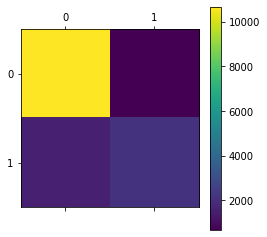

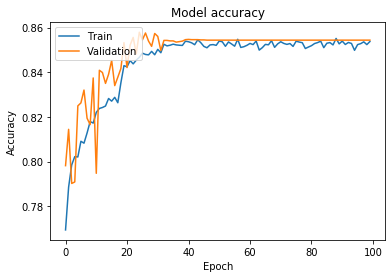

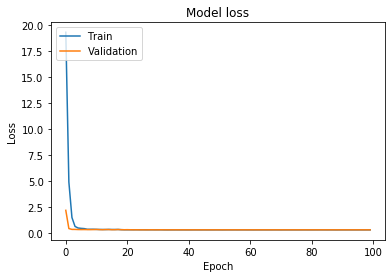

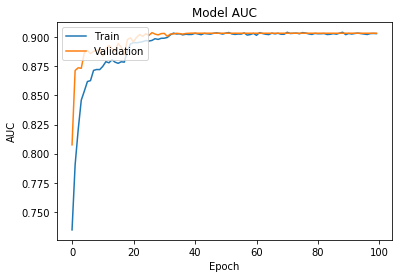

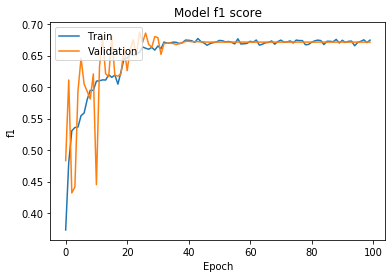

In [4]:
import matplotlib.pyplot as plt
# print(X_trainTrans.shape)


from keras.layers import Input, Dense, Dropout

# For a single-input model with 1 class (binary classification):
# A layer instance is callable on a tensor, and returns a tensor

inputs = Input(shape=(X_trainTrans.shape[1],)) # This returns a tensor

numInputNeurons = X_trainTrans.shape[1] # Use number of features as number of neurons
numHiddenLayerNeurons = 90
input_layer = Dense(numInputNeurons, activation='relu')(inputs)
drop_1 = Dropout(0.5)(input_layer)
hidden_layer = Dense(numHiddenLayerNeurons, activation='relu')(drop_1)
drop_2 = Dropout(0.5)(hidden_layer)
output_layer = Dense(1, activation='sigmoid')(drop_2) #softmax, tanh


# Create the model with Input layer and the Dense/Droput layers
from keras.models import Model
model = Model(inputs=inputs, outputs=output_layer)


# metrics to keep track of over every epoch
from keras import metrics
METRICS = [
    metrics.TruePositives(name='tp'),
    metrics.FalsePositives(name='fp'),
    metrics.TrueNegatives(name='tn'),
    metrics.FalseNegatives(name='fn'), 
    metrics.BinaryAccuracy(name='accuracy',threshold=0.5),
    metrics.Precision(name='precision'),
    metrics.Recall(name='recall'),
    metrics.AUC(name='auc'),
]
# For a binary classification problem
from keras.optimizers import RMSprop
RMSprop(learning_rate=0.01, rho=0.9)#0.001
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',#rmsprop,sgd
              metrics=METRICS)


# Recall we have an imbalanced class, lets try and fix that
# 'This can be useful to tell the model to "pay more attention" to samples from an under-represented class.'
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

# Train the model, iterating on the data in batches of 'n' samples
num_epochs = 100
size_of_batch = 50
validation_data = None
from keras.callbacks import ReduceLROnPlateau # Reduce the learning rate on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, 
                  mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
history = model.fit(x=X_trainTrans, y=y_train, epochs=num_epochs, batch_size=size_of_batch,
                    validation_data=validation_data, validation_split=.3,
                    shuffle=True, callbacks=[reduce_lr],class_weight=class_weights)


# Evaluate model over the test set
test_sample_weight = None
loss_and_metrics = model.evaluate(x=X_testTrans, y=y_test, batch_size=size_of_batch, sample_weight=None)
lossMetricsLegible = [[metricName,metricValue] for metricName, metricValue in zip(history.history.keys(), loss_and_metrics)]

print('\n\nModel performance metrics on the test:')
for ind in range(len(lossMetricsLegible)):
    print('\t',lossMetricsLegible[ind][0][4:],':',lossMetricsLegible[ind][1])
print('\n\n')
tp = loss_and_metrics[1]
fp = loss_and_metrics[2]
tn = loss_and_metrics[3]
fn = loss_and_metrics[4]
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
CM = np.array([[tn,fp],[fn,tp]])
print(CM)
im = plt.matshow(CM,label=['<=50K','>50K'])
plt.colorbar(im)
plt.show()

from keras.utils import plot_model
plot_model(model, to_file='savedModel/MLPmodel.png')


# print(history.history.keys()) #prints keys
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('kerasPlots/modelAccuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('kerasPlots/modelLoss.png')
plt.show()

# Plot training & validation AUC values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('kerasPlots/modelAUC.png')
plt.show()

f1 = 2*(np.array(history.history['precision'])*np.array(history.history['recall'])) / \
    (np.array(history.history['precision']) + np.array(history.history['recall']))
val_f1 = 2*(np.array(history.history['val_precision'])*np.array(history.history['val_recall'])) / \
    (np.array(history.history['val_precision']) + np.array(history.history['val_recall']))    
# Plot training & validation f1 values
plt.plot(f1)
plt.plot(val_f1)
plt.title('Model f1 score')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('kerasPlots/modelf1.png')
plt.show()



# Save the weights
model.save_weights('savedModel/MLPmodel_weights.h5')

# Save the model architecture
with open('savedModel/MLPmodel_architecture.json', 'w') as f:
    f.write(model.to_json())

## Load MLP model and tune Hyperparameters

In [ ]:
# from keras.models import model_from_json

# # Model reconstruction from JSON file
# with open('savedModel/MLPmodel_architecture.json', 'r') as f:
#     model = model_from_json(f.read())

# # Load weights into the new model
# model.load_weights('savedModel/MLPmodel_weights.h5')